In [1]:
from __future__ import print_function, division
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon

In [2]:
df = pd.read_csv('final_clean_data_201501_shorter.csv', index_col=0)
print ("Shape of data\n{}".format(df.shape))
df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Shape of data
(1245328, 29)


,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hour,dayofweek,dayofyear,timerange,day_and_hour,...,snowfall,snow_depth,temperature_max,temperature_min,fastest_2minute_windspeed,fog,heavy_fog,ice_pellets,smoke_haze,EVENT_TYPE
9134884,1,-73.988396,40.720039,-73.952820,40.718426,23,Monday,19,396,1923,...,0.0,0.0,42.0,36.0,16.1,0.0,0.0,0.0,0.0,-1
10247808,1,-73.970192,40.796490,-73.965637,40.807171,9,Wednesday,14,332,149,...,0.0,0.0,32.0,16.0,14.1,0.0,0.0,0.0,0.0,-1
5401286,1,-73.967049,40.788399,-73.983917,40.749298,8,Thursday,29,1750,298,...,0.0,6.0,36.0,19.0,14.1,0.0,0.0,0.0,0.0,-1
3801627,1,-73.974541,40.736504,-73.776344,40.645786,5,Friday,16,1506,165,...,0.0,0.0,43.0,20.0,21.0,0.0,0.0,0.0,1.0,-1
2176270,1,-73.992386,40.737835,-74.001976,40.739651,16,Tuesday,13,286,1316,...,0.0,0.0,36.0,17.0,18.1,0.0,0.0,0.0,0.0,-1


In [3]:
df = df[['dropoff_longitude','dropoff_latitude', 'geohash_dropoff']]

In [4]:
len(df.geohash_dropoff.unique())

1777

In [5]:
df['geohash_factorize'] = pd.factorize(df['geohash_dropoff'])[0]

In [6]:
# combine lat and lon to one column
df['lonlat']=list(zip(df.dropoff_longitude, df.dropoff_latitude))
# Create Point Geometry for based on lonlat column
df['geometry']=df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
df = gpd.GeoDataFrame(df)
df.head()

,dropoff_longitude,dropoff_latitude,geohash_dropoff,geohash_factorize,lonlat,geometry
9134884,-73.952820,40.718426,SHG2@,0,"(-73.95281982421875, 40.718425750732415)",POINT (-73.95281982421875 40.71842575073241)
10247808,-73.965637,40.807171,SHBJU,1,"(-73.96563720703125, 40.80717086791992)",POINT (-73.96563720703125 40.80717086791992)
5401286,-73.983917,40.749298,SHG1b,2,"(-73.98391723632812, 40.74929809570313)",POINT (-73.98391723632812 40.74929809570313)
3801627,-73.776344,40.645786,SHFkj,3,"(-73.7763442993164, 40.64578628540039)",POINT (-73.77634429931641 40.64578628540039)
2176270,-74.001976,40.739651,SHG1e,4,"(-74.00197601318358, 40.73965072631836)",POINT (-74.00197601318358 40.73965072631836)


In [7]:
len(df.geohash_dropoff.unique())

1777

In [8]:
import geohash_hilbert as ghh

In [9]:
ghh.rectangle('SHFkk')

{'bbox': (-73.795166015625, 40.6439208984375, -73.7841796875, 40.6494140625),
 'geometry': {'coordinates': [[(-73.795166015625, 40.6439208984375),
    (-73.7841796875, 40.6439208984375),
    (-73.7841796875, 40.6494140625),
    (-73.795166015625, 40.6494140625),
    (-73.795166015625, 40.6439208984375)]],
  'type': 'Polygon'},
 'properties': {'bits_per_char': 6,
  'code': 'SHFkk',
  'lat': 40.64666748046875,
  'lat_err': 0.00274658203125,
  'lng': -73.7896728515625,
  'lng_err': 0.0054931640625},
 'type': 'Feature'}

In [10]:
coords = ghh.rectangle('SHFkk')['geometry']['coordinates'][0]

In [11]:
poly_jfk = Polygon(coords)

In [12]:
type(df.geohash_dropoff.unique())

numpy.ndarray

In [13]:
df.drop_duplicates(subset='geohash_dropoff', inplace=True)

In [14]:
df.geohash_dropoff.unique()

array(['SHG2@', 'SHBJU', 'SHG1b', ..., 'SHBOl', 'SHGEk', 'SHGWK'], dtype=object)

In [15]:
geohashlist = list(df.geohash_dropoff.unique())

In [16]:
len(geohashlist)

1777

In [17]:
df.drop(['geometry', 'lonlat'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [18]:
#add a column of geometry to dataframe
geo = {}
for i in range(len(geohashlist)):
    coords = ghh.rectangle(geohashlist[i])['geometry']['coordinates'][0]
    poly = Polygon(coords)
    geo[i] = poly
s = pd.Series(geo, name='geometry')
geo = pd.DataFrame(s)
df = df.merge(geo, left_index=True, right_index=True)
df.head()

,dropoff_longitude,dropoff_latitude,geohash_dropoff,geohash_factorize,geometry
0,-73.952820,40.718426,SHG2@,0,"POLYGON ((-73.9599609375 40.71533203125, -73.9..."
1,-73.965637,40.807171,SHBJU,1,"POLYGON ((-73.970947265625 40.80322265625, -73..."
2,-73.983917,40.749298,SHG1b,2,"POLYGON ((-73.992919921875 40.748291015625, -7..."
3,-73.776344,40.645786,SHFkj,3,"POLYGON ((-73.7841796875 40.6439208984375, -73..."
4,-74.001976,40.739651,SHG1e,4,"POLYGON ((-74.00390625 40.7373046875, -73.9929..."


In [19]:
len(df)

1777

In [20]:
df.crs

In [21]:
df = gpd.GeoDataFrame(df)
df.crs = from_epsg(4326)
df = df.to_crs(epsg=2263)

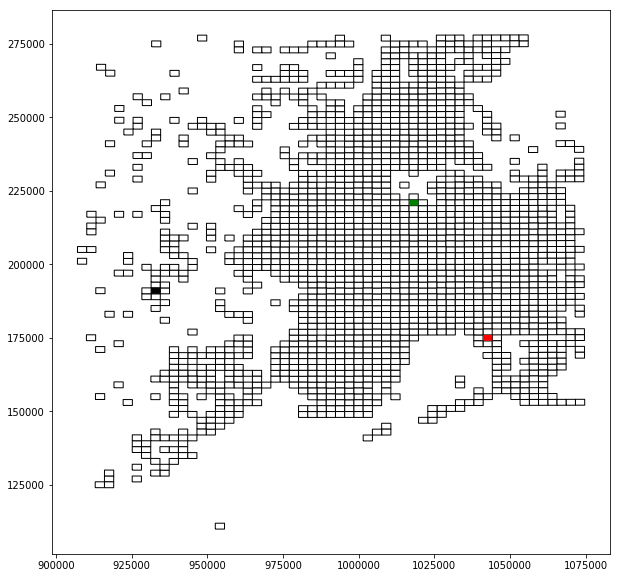

In [23]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
df.plot(column=None, color="white", edgecolor="black", ax=ax)
df[df.geohash_dropoff == 'SHFkk'].plot(ax=ax, color='r')
df[df.geohash_dropoff == 'SHG0t'].plot(ax=ax, color='g')
df[df.geohash_dropoff == 'SHGTe'].plot(ax=ax, color='k')
plt.savefig('geohash_nyc_shorter', dpi=500, transparent=True)
plt.show()